In [1]:
#Code adapted from https://github.com/TeaPearce/Bayesian_NN_Ensembles

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch


In [63]:
# NN options

prior_scale_std=2.
data_noise_std = 0.01 # estimated noise variance
L=[100]   # Layers  
n_ensemble =20	# no. NNs in ensemble
mid_act= nn.ReLU() #nn.Sigmoid()   nn.Tanh()



n_data = 6 #Number of data points

# optimisation options
epochs = 1000 
l_rate = 0.01




In [64]:
data_noise = data_noise_std**2
prior_scale=prior_scale_std**2
W_var=[]   # Prior Variance for the weights between each layer. 
n_input=1

for n_hidden in L:
    W_var.append(prior_scale/n_input)
    n_input=n_hidden
W_var.append(prior_scale/n_input)
    
W_lambda=[data_noise/w for w in W_var]    

In [65]:
def fn_make_data():
    # create some data[1., 4.5, 5.1, 6., 8., 9.]
    
    x_train = np.atleast_2d([1., 4.5, 5.1, 6., 8., 9.]).T
    x_train = x_train/5. - 1
    y_train = x_train * np.sin(x_train*5.)
    x_train = x_train
    # create validation data - here we'll just a 1-d grid
    x_val = np.atleast_2d(np.linspace(-3, 3, 100)).T
    y_val = np.expand_dims(x_val[:,0],1) # just dummy data
    
    return x_train, y_train, x_val, y_val



# create some data
x_train, y_train, x_test, y_test = fn_make_data()

x = torch.tensor(x_train).float()
y = torch.tensor(y_train).float()


In [66]:
class NN(nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, hiddens=[100,100]):
        super().__init__()

        
        layers = []
        for hidden in hiddens:
            layers.append(nn.Linear(n_inputs, hidden))
            layers.append(mid_act)
            n_inputs = hidden

        if n_outputs is not None:
            layers.append(nn.Linear(hidden, n_outputs,bias=False))

        self.layers = nn.Sequential(*layers)
        
        
        
    def forward(self, obs):
        return self.layers(obs)


In [67]:

def fn_make_NN(activation_in='relu'):
    n_in, D_out = 1, 1 # input and output dimension
    
    model=NN(1,1,L)
    
    for i in range(len(L)):
        model.layers[2*i].weight.data.normal_(0.0, np.sqrt(W_var[i]))
        model.layers[2*i].bias.data.normal_(0.0, np.sqrt(W_var[i]))
    
    model.layers[2*len(L)].weight.data.normal_(0.0, np.sqrt(W_var[-1]))
    
    return model

def fn_predict_ensemble(NNs, x_test):
	''' fn to predict given a list of NNs (an ensemble)''' 
	y_preds = []
	for m in range(len(NNs)):
		y_preds.append(NNs[m](torch.tensor(x_test).float()).data.numpy())
	y_preds = np.array(y_preds)

	y_preds_mu = np.mean(y_preds,axis=0)
	y_preds_std = np.std(y_preds,axis=0)

	return y_preds, y_preds_mu, y_preds_std

In [68]:
# create the NNs
NNs=[]
#for m in range(n_ensemble):
	#NNs.append(fn_make_NN(reg=reg, activation_in=activation_in))
for m in range(n_ensemble):
    NNs.append(fn_make_NN())

(-3, 3)

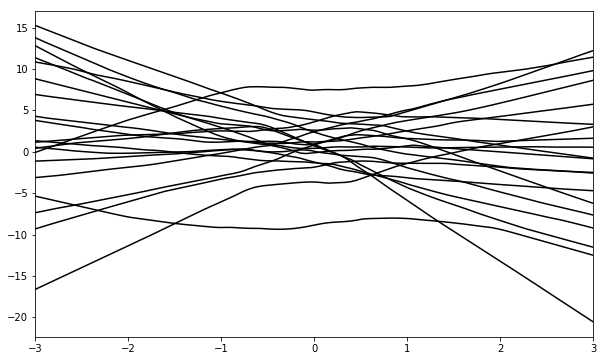

In [69]:
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in range(0,n_ensemble):
     ax.plot(x_test, y_preds[m], 'k')
ax.set_xlim(-3, 3)


In [70]:
W=[]
B=[]
n_inputs=1
for i in range(len(L)):
        # set anchoring points (different set for each NN)
        n_hidden=L[i]
        W1_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[i]),size=[n_hidden,n_inputs])
        b1_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[i]),size=[n_hidden])
        W1_anc = torch.tensor(W1_anc).float()
        b1_anc = torch.tensor(b1_anc).float()
        W.append(W1_anc)
        B.append(b1_anc)     
        n_inputs=n_hidden
W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[-1]),size=[1,n_inputs])
W_last_anc = torch.tensor(W_last_anc).float()


In [71]:


# do training
NNs_hist_train=[];
for m in range(n_ensemble):
    print('-- training: ' + str(m+1) + ' of ' + str(n_ensemble) + ' NNs --')
    
    # set up loss
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(NNs[m].parameters(), lr=l_rate)
    #### WE Draw the Anchor points from a normal distribution ( prior)
    W=[]
    B=[]
    n_inputs=1
    for i in range(len(L)):
        # set anchoring points (different set for each NN)
        n_hidden=L[i]
        W_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[i]),size=[n_hidden,n_inputs])
        b_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[i]),size=[n_hidden])
        W_anc = torch.tensor(W1_anc).float()
        b_anc = torch.tensor(b1_anc).float()
        W.append(W_anc)
        B.append(b_anc)     
        n_inputs=n_hidden
    
    W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[-1]),size=[1,n_inputs])
    W_last_anc = torch.tensor(W_last_anc).float()
    W.append(W_last_anc)
    
    NNs_losses=[]
    for _ in range(epochs):
        y_pred = NNs[m](x)
        #loss = loss_fn(y_pred, y)
        loss = ((y_pred-y)**2).mean()
        
        # set up reg loss
        l2 = 0
        for i in range(len(L)):
            l2 += W_lambda[i]/n_data * torch.mul(NNs[m].layers[2*i].weight - W[i], NNs[m].layers[2*i].weight - W[i]).sum()
            l2 += W_lambda[i]/n_data * torch.mul(NNs[m].layers[2*i].bias - B[i], NNs[m].layers[2*i].bias - B[i]).sum()
            
        l2 += W_lambda[-1]/n_data * torch.mul(NNs[m].layers[2*len(L)].weight - W[len(L)], NNs[m].layers[2*len(L)].weight - W[len(L)]).sum()
        
        loss = loss + l2
        
        # run gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        NNs_losses.append(loss.item())
    NNs_hist_train.append(NNs_losses)

-- training: 1 of 20 NNs --
-- training: 2 of 20 NNs --
-- training: 3 of 20 NNs --
-- training: 4 of 20 NNs --
-- training: 5 of 20 NNs --
-- training: 6 of 20 NNs --
-- training: 7 of 20 NNs --
-- training: 8 of 20 NNs --
-- training: 9 of 20 NNs --
-- training: 10 of 20 NNs --
-- training: 11 of 20 NNs --
-- training: 12 of 20 NNs --
-- training: 13 of 20 NNs --
-- training: 14 of 20 NNs --
-- training: 15 of 20 NNs --
-- training: 16 of 20 NNs --
-- training: 17 of 20 NNs --
-- training: 18 of 20 NNs --
-- training: 19 of 20 NNs --
-- training: 20 of 20 NNs --


Text(0.5, 1.0, ' Anchored Ensembling ')

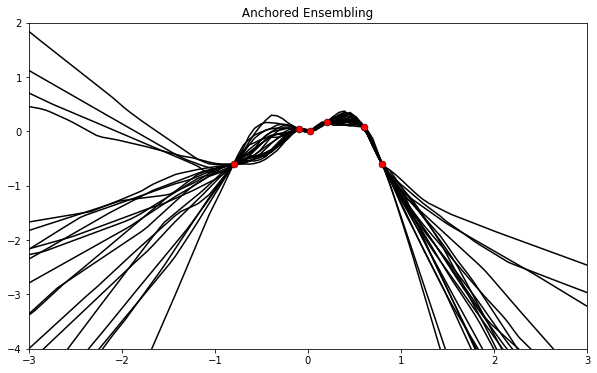

In [72]:
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NNs,x_test)

# plot predictions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in range(0,n_ensemble):
    ax.plot(x_test, y_preds[m], 'k')
ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
ax.set_title(" Anchored Ensembling ")


Text(0.5, 1.0, 'Ensemble, 100 Neurons')

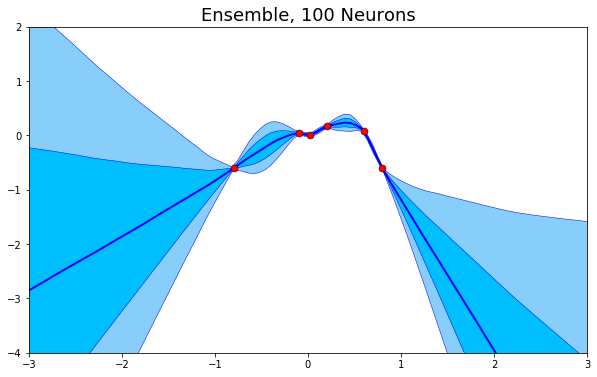

In [74]:

# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std)+data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
ax.set_title("Ensemble, 100 Neurons",fontsize=18)
